## RAG Evaluation with Snowflake Cortex

This notebook demonstrates how to use Snowflake Cortex to generate synthetic questions and answers for evaluating a RAG application.

This notebooks is based on the [Hugging Face RAG evaluation notebook](https://huggingface.co/learn/cookbook/rag_evaluation), but using Cortex to generate the synthetic questions and answers and performing the operations in Snowpark (and not on the local machine).

There are four main steps in this notebook:
-   **Step 1**: Generating Synthetic Questions and Answers
-   **Step 2**: Evaluating Synthetic Questions for Groundness, Relevance, and Context
-   **Step 3**: Getting Predictions for Synthetic Questions
-   **Step 4**: Evaluating Performance on Synthetic Questions

The notebook uses `mixtral-8x7b` for generarting questions/answers and `mistral-large` for the final evaluation on the synthetic questions.

There are many ways to evaluate a RAG model, and this notebook is just one example. The evaluation metrics used in this notebook are not exhaustive, and you may want to consider additional metrics when evaluating your RAG model. This notebook was put together for one project, so plenty of room for improvement and customization.

In [1]:
# Snowpark for Python
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import Variant
from snowflake.snowpark.version import VERSION

# Snowpark ML
# Misc
import pandas as pd
import json
import logging 
logger = logging.getLogger("snowflake.snowpark.session")
logger.setLevel(logging.ERROR)

from snowflake import connector
from snowflake.ml.utils import connection_params

In [2]:
with open('../../creds.json') as f:
    data = json.load(f)
    USERNAME = data['user']
    PASSWORD = data['password']
    SF_ACCOUNT = data['account']
    SF_WH = data['warehouse']

CONNECTION_PARAMETERS = {
   "account": SF_ACCOUNT,
   "user": USERNAME,
   "password": PASSWORD,
}

session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [3]:
snowflake_environment = session.sql('select current_user(), current_version()').collect()
snowpark_version = VERSION

from snowflake.ml import version
mlversion = version.VERSION


# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))
print('Snowflake ML version        : {}.{}.{}'.format(mlversion[0],mlversion[2],mlversion[4]))

User                        : RSHAH
Role                        : "RAJIV"
Database                    : "RAJIV"
Schema                      : "DOCAI"
Warehouse                   : "RAJIV"
Snowflake version           : 8.18.0
Snowpark for Python version : 1.11.1
Snowflake ML version        : 1.5.0


## 1. Generating Synthetic Questions and Answers
My starting point is the [SEC RAG example](https://medium.com/snowflake/retrieval-augmented-generation-rag-application-using-snowflake-cortex-and-streamlit-9cb261e81c2e) where the data has already been chunked. I then filter down to just the Rivian entries. 

Feel free to modify this, the goal is a representative set of topics for the synthetic questions.

In [4]:
from snowflake.snowpark.functions import col
import snowflake.snowpark.functions as f
from snowflake.snowpark.functions import col, split, lit, regexp_extract
from snowflake.cortex import Complete


article_df = session.table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K")
filtered_df = article_df.filter(col("company_name").like("RIVIAN%"))

# Now you can perform further operations on filtered_df, like displaying the data
filtered_df.show()


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDDING"                                         |"DOCUMENT_INDEX_ROWNUM"  |"ROWNUM"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
# Count the number of starting rows
filtered_df.count()

497

You will only want to select a subset of the chunks to build your generated examples. The first time you run this, start small, but your final evaluation should probably be at least 50 questions up to hundreds.

In [6]:
shuffled_df = filtered_df.sample(n=40)
shuffled_df.count()

40

Let's build the Q&A pairs for the RAG evaluation.

In [7]:
QA_generation_prompt = """
Your task is to write a factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question should be formulated in the same style as questions users could ask in a search engine.
This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: """

In [8]:
outdf = shuffled_df.withColumn(
    "GenQA",
    Complete(
        model='mixtral-8x7b',prompt = f.concat(
            f.lit(QA_generation_prompt),
            f.col("CONTENT_CHUNK"),
            f.lit("\n Output:::")
            ))
)
outputs = outdf.to_pandas()

Complete() is experimental since 1.0.12. Do not use it in production. 


In [9]:
outputs.GENQA[1]

' Factoid question: How many shares of common stock were issued and outstanding by Rivian Automotive, Inc. as of December 31, 2022?\nAnswer: 926 shares'

In [10]:
outdf = outdf.withColumn("split_col", split(col("GENQA"), lit('\n')))

# Create new columns 'GENQ' and 'GENA' by accessing elements of the array
outdf = outdf.withColumn("GENQ", col("split_col")[0])
outdf = outdf.withColumn("GENA", col("split_col")[1])

outdf.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDDING"                                         |"DOCUMENT_INDEX_ROWNUM"  |"ROWNUM"  |"GENQA"                                             |"SPLIT_COL"                                         |"GENQ"   

In [11]:
#save our work periodically
table_name = "RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA"  # Specify your new table name here
outdf.write.mode("overwrite").save_as_table(table_name)

In [12]:
outdf = session.table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")

## 2. Evaluating Synthetic Questions for Groundness, Relevance, and Context
The questions generated by the previous agent can have many flaws: we should do a quality check before validating these questions.

### Groundness Criteria

In [13]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a integer between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: """

In [14]:
outdf = outdf.withColumn(
    "Eval_Groundness",
    Complete(
        model='mixtral-8x7b',prompt = f.concat(
            f.lit(question_groundedness_critique_prompt),
            f.col("GENQ"),
            f.lit("\n Context: "),
            f.col("CONTENT_CHUNK"),
            f.lit("\n Answer:::")
            ))
)

In [15]:
## you can always pull this into pandas to see the results
outputs = outdf.to_pandas()
outputs.EVAL_GROUNDNESS[4]

' Evaluation: The context provides a detailed explanation of the potential consequences if the business is unable to adequately service their vehicles. It mentions adverse publicity, regulatory action, safety recall, fines, loss of permits and licenses, and negative impact on the business, prospects, financial condition, results of operations, and cash flows. Therefore, the question is clearly and unambiguously answerable with the context.\n\nTotal rating: 5'

Let's split out the score,which will later filter on.

In [16]:
# Extracting the score by taking the rightmost character of the last part of split_rating
outdf = outdf.withColumn("score_EG", regexp_extract(col("EVAL_GROUNDNESS"), r"Total rating:\s*(\d)", 1))

outdf.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDDING"                                         |"DOCUMENT_INDEX_ROWNUM"  |"ROWNUM"  |"GENQA"                                          

### Relevance Criteria

In [17]:
question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to analysts.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as an integer between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: """

In [18]:
outdf = outdf.withColumn(
    "EVAL_RELEVANCE",
    Complete(
        model='mixtral-8x7b',prompt = f.concat(
            f.lit(question_relevance_critique_prompt),
            f.col("GENQ"),
            f.lit("\n Answer:::")
            ))
)
# Extracting the score by taking the rightmost character of the last part of split_rating
outdf = outdf.withColumn("score_ER", regexp_extract(col("EVAL_RELEVANCE"), r"Total rating:\s*(\d)", 1))

outdf.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDDING"                                         |"DOCUMENT_INDEX_ROWN

### Context Criteria

In [19]:
question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independant this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independant from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as an integer between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: """

In [20]:
outdf = outdf.withColumn(
    "EVAL_CONTEXT",
    Complete(
        model='mixtral-8x7b',prompt = f.concat(
            f.lit(question_relevance_critique_prompt),
            f.col("GENQ"),
            f.lit("\n Answer:::")
            ))
)

# Extracting the score by taking the rightmost character of the last part of split_rating
outdf = outdf.withColumn("score_EC", regexp_extract(col("EVAL_CONTEXT"), r"Total rating:\s*(\d)", 1))

# Show results to verify
outdf.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEC_DOCUMENT_ID"          |"DOCUMENT_TYPE"   |"COMPANY_NAME"                |"SIC_CODE_CATEGORY"      |"SIC_CODE_DESCRIPTION"                 |"COUNTRY"  |"PERIOD_END_DATE"  |"CONTENT_CHUNK"                                     |"START_INDEX"  |"EMBEDD

In [21]:
outdf.write.saveAsTable("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA_All", mode="overwrite")

Let's keep only the questions that have scored well, by filtering on the score. This part may error on you if the scoring wasn't done correctly. I need to rework this scoring to be more robust. Sometimes the models don't output a number and this affects the following filtering.

In [23]:
# Assuming 'outdf' is your DataFrame
filtered_df = outdf.filter(
    col("SCORE_EC").isin(["4", "5"]) &
    col("SCORE_ER").isin(["4", "5"]) &
    col("SCORE_EG").isin(["4", "5"])
)

# To count the number of rows in the filtered DataFrame
row_count = filtered_df.count()
print(row_count)

28


In [24]:
selected_df = filtered_df.select("CONTENT_CHUNK", "GENQ", "GENA")
# Now, to save this DataFrame as a new table in Snowflake
selected_df.write.mode("overwrite").saveAsTable("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")

## 3. Get Predictions for Synthetic Questions

In [25]:
from snowflake.snowpark.functions import col
import snowflake.snowpark.functions as f
from snowflake.snowpark.functions import col, split, lit, regexp_extract
from snowflake.cortex import Complete

Let's get predictions for the snythetic questions we have already created.

In [26]:
gen_qa = session.table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")
df_gen_qa = gen_qa.toPandas()
df_gen_qa.head()

,CONTENT_CHUNK,GENQ,GENA
0,rivn-20221231 UNITED STATES SECURITIES AND EXC...,""" Factoid question: What is the trading symbol...","""Answer: The trading symbol for Rivian Automot..."
1,. We do not have any control over these analys...,""" Factoid question: Why might demand for Rivia...","""Answer: Demand for Rivian Automotive's Class ..."
2,". Our vehicles use lithium-ion battery cells, ...",""" Factoid question: What type of battery cells...","""Answer: Our vehicles use lithium-ion battery ..."
3,. Such damage or injury could also lead to adv...,""" Factoid question: What could be the potentia...","""Answer: The business, prospects, financial co..."
4,. We use our Investor Relations website as a m...,""" Factoid question: What is one way the compan...","""Answer: The company uses its Investor Relatio..."


In [27]:
def get_response(session, question):
    # Prepare the SQL command
    sql_command = f"""
    WITH question AS (
        SELECT '{question.replace("'", "''")}' AS question,
               snowflake.cortex.embed_text('e5-base-v2', question) AS embedding
    ),
    context AS (
        SELECT content_chunk AS context,
               sec_document_id,
               start_index AS document_index
        FROM RAJIV.PUBLIC.CONTENT_CHUNKS_10K AS content,
             question
        WHERE company_name = 'RIVIAN AUTOMOTIVE, INC. / DE'
        ORDER BY vector_cosine_distance(content.embedding, question.embedding) DESC
        LIMIT 1
    ),
    response AS (
        SELECT snowflake.cortex.complete('mistral-7b',
                                         'Use only the context provided to answer the question.' ||
                                         '### ' || 'Context: ' || context.context ||
                                         '### ' || 'Question: ' || question.question ||
                                         'Answer: ') AS response
        FROM context, question
    )
    SELECT response FROM response
    """

    #print("Executing SQL command:", sql_command)  # Log the SQL command

    # Execute the SQL command
    result = session.sql(sql_command).collect()

    if result:
        return result[0][0]
    else:
        return "No suitable answer found."


In [28]:
import pandas as pd

# Assume 'session' is your Snowflake session object and 'df_gen_qa' is your pandas DataFrame
df_gen_qa['RESPONSE'] = df_gen_qa['GENQ'].apply(lambda question: get_response(session, question))

# Now df_gen_qa has an additional column 'Response' with the answers
print(df_gen_qa)


                                        CONTENT_CHUNK  \
0   rivn-20221231 UNITED STATES SECURITIES AND EXC...   
1   . We do not have any control over these analys...   
2   . Our vehicles use lithium-ion battery cells, ...   
3   . Such damage or injury could also lead to adv...   
4   . We use our Investor Relations website as a m...   
5   . The grant-date fair value of stock options g...   
6   . Any reduction, elimination, or discriminator...   
7   . We market our ability to provide our custome...   
8   . We primarily rely on Amazon Web Services in ...   
9   . In addition, our independent registered publ...   
10  . Errors in the design, implementation or exec...   
11  . The Company is subject to taxation and files...   
12  . Item 9B. Other Information None. Item 9C. Di...   
13  . For example, we will not be able to utilize ...   
14  . As our vehicles are produced, we will need t...   
15  . These services will generate long-term brand...   
16  . In 2021, changes to the S

In [29]:
df_gen_qa.head()

,CONTENT_CHUNK,GENQ,GENA,RESPONSE
0,rivn-20221231 UNITED STATES SECURITIES AND EXC...,""" Factoid question: What is the trading symbol...","""Answer: The trading symbol for Rivian Automot...",RIVN
1,. We do not have any control over these analys...,""" Factoid question: Why might demand for Rivia...","""Answer: Demand for Rivian Automotive's Class ...",Demand for Rivian Automotive's Class A common...
2,". Our vehicles use lithium-ion battery cells, ...",""" Factoid question: What type of battery cells...","""Answer: Our vehicles use lithium-ion battery ...",The vehicles use lithium-ion battery cells. I...
3,. Such damage or injury could also lead to adv...,""" Factoid question: What could be the potentia...","""Answer: The business, prospects, financial co...",The potential consequences for the business i...
4,. We use our Investor Relations website as a m...,""" Factoid question: What is one way the compan...","""Answer: The company uses its Investor Relatio...",The company discloses material information to...


In [30]:
snowpark_df = session.createDataFrame(df_gen_qa)
snowpark_df.write.saveAsTable("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA", mode="overwrite")

## 4. Evaluate Performance on Synthetic Questions

Let's now start to analyze the results. In this notebooks, I use one criteria, but three are many more criteria you can use to evaluate the performance of the RAG model. For example, [Ragas](https://docs.ragas.io/en/stable/getstarted/evaluation.html#get-started-evaluation) does provides several metrics to evaluate various aspects of your RAG systems:

Retriever: Offers context_precision and context_recall that measure the performance of your retrieval system.

Generator (LLM): Provides faithfulness that measures hallucinations and answer_relevancy that measures how relevant the answers are to the question.

In [31]:
snowpark_df = session.table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA").select("GENQ", "GENA", "RESPONSE")
snowpark_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------
|"GENQ"                                              |"GENA"                                              |"RESPONSE"                                          |
----------------------------------------------------------------------------------------------------------------------------------------------------------------
|" Factoid question: What is the trading symbol ...  |"Answer: The trading symbol for Rivian Automoti...  | RIVN                                               |
|" Factoid question: Why might demand for Rivian...  |"Answer: Demand for Rivian Automotive's Class A...  | Demand for Rivian Automotive's Class A common ...  |
|" Factoid question: What type of battery cells ...  |"Answer: Our vehicles use lithium-ion battery c...  | The vehicles use lithium-ion battery cells. If...  |
|" Factoid question: What could be

In [32]:
EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

Answer:::
Feedback: (your feedback for the rating, as a text)
Total score: (your score, as an integer between 1 and 5)
"""

In [33]:
part0 = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate: """
part1 = """###Response to evaluate: """

part2 = """###Reference Answer (Score 5): """

In [34]:
part3 = """###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

Answer:::
Feedback: (your feedback for the rating, as a text)
Total score: (an integer between 1 and 5)"""

In [35]:
from snowflake.snowpark.functions import col, regexp_extract, coalesce, lit

snowpark_df = snowpark_df.withColumn(
    "EVAL_CRITIQUE",
    Complete(
        model='mistral-large',prompt = f.concat(
            f.lit(part0),
            f.col("GENQ"),
            f.lit(part1),
            f.col("RESPONSE"),
            f.lit(part2),
            f.col("GENA"),
            f.lit(part3)
            ))
)

# Extracting the score by taking the rightmost character of the last part of split_rating
#snowpark_df = snowpark_df.withColumn("SCORE_EVAL", regexp_extract(col("EVAL_CRITIQUE"), r"Total score:\s*(\d)", 1).cast("int"))
snowpark_df = snowpark_df.withColumn("SCORE_EVAL",
    coalesce(regexp_extract(col("EVAL_CRITIQUE"), r"Total score:\s*(\d)", 1), lit("0")))

snowpark_df.write.mode("overwrite").save_as_table("RAJIV.PUBLIC.CONTENT_CHUNKS_10K_GQA")
# Show results to verify
snowpark_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"GENQ"                                              |"GENA"                                              |"RESPONSE"                                          |"EVAL_CRITIQUE"                                     |"SCORE_EVAL"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|" Factoid question: What is the trading symbol ...  |"Answer: The trading symbol for Rivian Automoti...  | RIVN                                               |                                                    |5             |
|                                                    |                              

#### Pulling into pandas for the final calculations

In [36]:
output = snowpark_df.toPandas()

In [37]:
output['SCORE_EVAL'] = pd.to_numeric(output['SCORE_EVAL'], errors='coerce')

In [38]:
summary_stats = output['SCORE_EVAL'].describe()
print(summary_stats)

count    17.000000
mean      4.823529
std       0.727607
min       2.000000
25%       5.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: SCORE_EVAL, dtype: float64


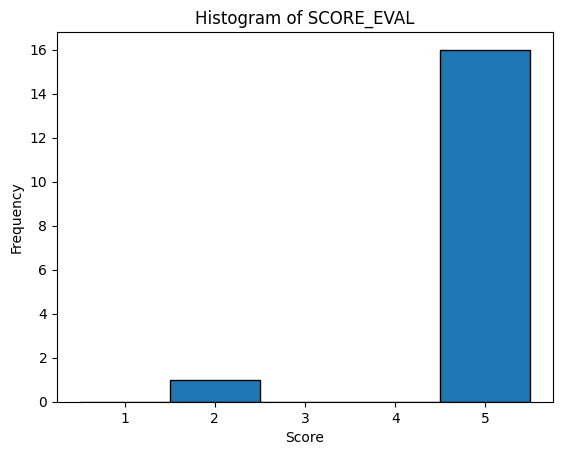

In [39]:
import matplotlib.pyplot as plt

# Plotting histogram
plt.hist(output['SCORE_EVAL'], bins=range(1, 7), edgecolor='black', align='left')  # bins from 1 to 5
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of SCORE_EVAL')
plt.xticks(range(1, 6))  # Setting x-ticks to show each score
plt.show()

We can calculate an accuracy here to use as a baseline. Next we can start improving parts of the model and verify the accuracy goes up. Start digging into why the model was inaccurate in some cases!

In [40]:
scores = (output["SCORE_EVAL"] - 1) / 4
print (scores.mean())

0.9558823529411765
